## Ligações em Leucócitos
Calcularemos a equação:
$$
\frac{d P_{i}}{dt} = k_{ad} P_{i-1} + (i+1)k_{r}^{i+1}P_{i+1} - (k_{ad} + i k_{r}^{i}) P_{i}
$$

em que
$$
\frac{dP_{0}}{dt} = (k_{r}^{1} - k_{ad}) P_{1}
$$
e
$$
\frac{d P_{n}}{dt} = k_{ad} P_{n-1} - (k_{ad} + n k^{n}_{r}) P_n
$$

com as constantes:
$$k_{ad} = k_{f} N_{L} R$$
$$k^{i}_{r} = k^{0}_{r} \exp \left(\frac{x_{a} F}{i k_{b} T} \right)$$

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from graph_style import apply_authentic_seaborn_style as style_gustavo

In [26]:
# ParâmetrosBaseados na legenda da Figura 12.14 e no texto

N_BONDS_INITIAL = 5  # Número inicial de ligações (n)
KR0 = 1.0            # Taxa de dissociação sem estresse (k_r^0) [1/s]
XA = 0.08e-9         # Distância característica da ligação [m]
TEMP = 310           # Temperatura absoluta [K]
KB = 1.380649e-23    # Constante de Boltzmann [J/K]

# Forças a serem testadas [pN]
forces_pN = [0, 10, 50, 100]
forces_N = [f * 1e-12 for f in forces_pN] # Converte para pico Newtons

# Intervalo de tempo para a simulação [s]
t_span = [0, 3]
t_eval = np.linspace(t_span[0], t_span[1], 300)

In [27]:
def detachment_model(t, y, F, n_bonds, kr0, xa, T, kB):
    """
    Sistema de EDOs para o descolamento celular.
    t: tempo
    y: vetor de probabilidades [P0, P1, ..., Pn]
    F: força aplicada
    n_bonds: número total inicial de ligações
    """
    # y[i] corresponde a P_i
    P = y
    dydt = np.zeros_like(P)
    
    # Calcula as taxas de dissociação k_r^i para i = 1 a n
    kr_vec = np.zeros(n_bonds)
    for i in range(1, n_bonds + 1):
        # Modelo de Bell (Eq. 12.4.6)
        exponent = (xa * F) / (i * kB * T)
        kr_vec[i-1] = kr0 * np.exp(exponent)

    # dP0/dt = k_r^1 * P1
    dydt[0] = kr_vec[0] * P[1]
    
    # dPi/dt para i = 1 a n-1
    for i in range(1, n_bonds):
        # dPi/dt = (i+1)*k_r^(i+1)*P(i+1) - i*k_r^i*P(i)
        dydt[i] = (i + 1) * kr_vec[i] * P[i+1] - i * kr_vec[i-1] * P[i]
        
    # dPn/dt = -n * k_r^n * Pn
    dydt[n_bonds] = -n_bonds * kr_vec[n_bonds - 1] * P[n_bonds]
    
    return dydt

In [28]:
def solve_rk4(f, t_span, y0, h, *args):
    """
    Resolve um sistema de EDOs usando o método RK4 de passo fixo.
    f: função da derivada, f(t, y, *args)
    t_span: [t_inicial, t_final]
    y0: condições iniciais
    h: tamanho do passo
    *args: argumentos extras para a função f
    """
    # Garante que y0 é um array numpy
    y0 = np.asarray(y0)
    
    # Calcula o número de passos e os pontos de tempo
    num_steps = int((t_span[1] - t_span[0]) / h)
    time_points = np.linspace(t_span[0], t_span[1], num_steps + 1)
    
    # Inicializa o array para armazenar os resultados
    # y_results terá formato (num_steps+1, len(y0))
    y_results = np.zeros((num_steps + 1, len(y0)))
    y_results[0] = y0
    
    # Loop principal do RK4
    for i in range(num_steps):
        t_i = time_points[i]
        y_i = y_results[i]
        
        # Calcula as quatro inclinações (k1, k2, k3, k4)
        k1 = f(t_i, y_i, *args)
        k2 = f(t_i + h/2, y_i + h * k1/2, *args)
        k3 = f(t_i + h/2, y_i + h * k2/2, *args)
        k4 = f(t_i + h, y_i + h * k3, *args)
        
        # Calcula o próximo y
        y_next = y_i + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
        y_results[i+1] = y_next
        
    return time_points, y_results

Estilo pessoal Seaborn aplicado com sucesso (Modo Escuro)!


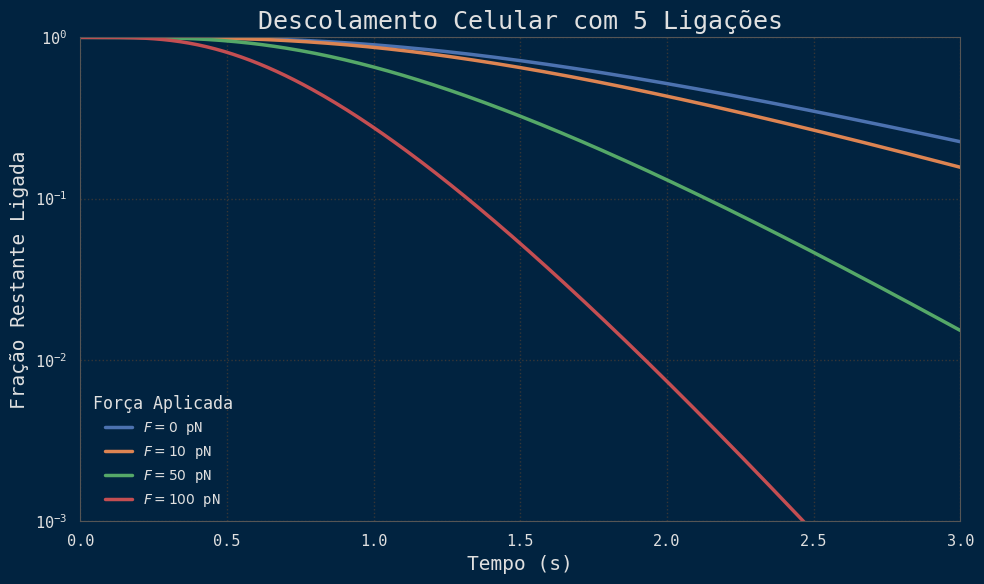

In [32]:
# --- Execução da Simulação e Plotagem ---
# Tamanho do passo para o RK4
step_size_h = 0.01

# Configuração do Gráfico
# plt.style.use('seaborn-v0_8-whitegrid')
style_gustavo()

fig, ax = plt.subplots(figsize=(10, 6))

# Condições iniciais
y0 = np.zeros(N_BONDS_INITIAL + 1)
y0[N_BONDS_INITIAL] = 1.0

# Loop para cada valor de força
for force_N, force_pN in zip(forces_N, forces_pN):
    
    # Resolve o sistema de EDOs usando nosso solver RK4
    time_pts, y_sols = solve_rk4(
        detachment_model,
        t_span,
        y0,
        step_size_h,
        force_N, N_BONDS_INITIAL, KR0, XA, TEMP, KB
    )
    
    # y_sols está em formato (tempo, prob), precisamos transpor para somar
    # probabilidades[i] será o vetor de P_i ao longo do tempo
    probabilities = y_sols.T
    
    # Calcula a fração restante ligada
    fraction_remaining_bound = np.sum(probabilities[1:], axis=0)
    
    # Plota o resultado
    ax.plot(time_pts, fraction_remaining_bound, label=f'$F = {force_pN}$ pN')

# --- Finalização do Gráfico ---
ax.set_yscale('log')
ax.set_ylim(0.001, 1.0)
ax.set_xlim(t_span[0], t_span[1])
ax.set_xlabel('Tempo (s)')
ax.set_ylabel('Fração Restante Ligada')
ax.set_title(f'Descolamento Celular com {N_BONDS_INITIAL} Ligações')
ax.legend(title='Força Aplicada')
ax.tick_params(axis='both', which='major')
# sns.despine()
plt.tight_layout()
plt.show()